## [Computational Social Science] Project 5: Natural Language Processing

In this project, you will use natural language processing techniques to explore a dataset containing tweets from members of the 116th United States Congress that met from January 3, 2019 to January 2, 2021. The dataset has also been cleaned to contain information about each legislator. Concretely, you will do the following:

* Preprocess the text of legislators' tweets
* Conduct Exploratory Data Analysis of the text
* Use sentiment analysis to explore differences between legislators' tweets
* Featurize text with manual feature engineering, frequency-based, and vector-based techniques
* Predict legislators' political parties and whether they are a Senator or Representative

You will explore two questions that relate to two central findings in political science and examine how they relate to the text of legislators' tweets. First, political scientists have argued that U.S. politics is currently highly polarized relative to other periods in American history, but also that the polarization is asymmetric. Historically, there were several conservative Democrats (i.e. "blue dog Democrats") and liberal Republicans (i.e. "Rockefeller Republicans"), as measured by popular measurement tools like [DW-NOMINATE](https://en.wikipedia.org/wiki/NOMINATE_(scaling_method)#:~:text=DW\%2DNOMINATE\%20scores\%20have\%20been,in\%20the\%20liberal\%2Dconservative\%20scale.). However, in the last few years, there are few if any examples of any Democrat in Congress being further to the right than any Republican and vice versa. At the same time, scholars have argued that this polarization is mostly a function of the Republican party moving further right than the Democratic party has moved left. **Does this sort of asymmetric polarization show up in how politicians communicate to their constituents through tweets?**

Second, the U.S. Congress is a bicameral legislature, and there has long been debate about partisanship in the Senate versus the House. The House of Representatives is apportioned by population and all members serve two year terms. In the Senate, each state receives two Senators and each Senator serves a term of six years. For a variety of reasons (smaller chamber size, more insulation from the voters, rules and norms like the filibuster, etc.), the Senate has been argued to be the "cooling saucer" of Congress in that it is more bipartisan and moderate than the House. **Does the theory that the Senate is more moderate have support in Senators' tweets?**

**Note**: See the project handout for more details on caveats and the data dictionary.

In [1]:
# pandas and numpy
import pandas as pd
import numpy as numpy

# punctuation, stop words and English language model
from string import punctuation
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_sm
nlp = en_core_web_sm.load()

# textblob
from textblob import TextBlob

# countvectorizer, tfidfvectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# gensim
import gensim
from gensim import models

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
#pip install emoji

# ooh do we need to do this? -P 

In [3]:
congress_tweets = pd.read_csv("data/116th Congressional Tweets and Demographics.csv")
# fill in this line of code with a sufficient number of tweets, depending on your computational resources
#congress_tweets = congress_tweets.sample(...)
congress_tweets.head()

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share
0,1.081010e+18,RepByrne,2019-01-03T21:23:00-05:00,Great news for Baldwin County! The economy of ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
1,1.080880e+18,RepByrne,2019-01-03T12:30:38-05:00,Outstanding news today from @Airbus! @JetBlue ...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
2,1.080830e+18,RepByrne,2019-01-03T09:12:07-05:00,RT @senatemajldr Democrats will have to get se...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
3,1.080890e+18,RepByrne,2019-01-03T13:20:53-05:00,Here is a sign of things to come: As Democrats...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"
4,1.080870e+18,RepByrne,2019-01-03T12:10:26-05:00,Let's understand what we're dealing with here:...,Bradley Byrne,Rep,8-Jan-14,2/16/1955,M,AL,1,Republican,"1,318,255","729,547","795,696","1,255,925"


In [4]:
# sample 1000 rows for writing code
congress_tweets = congress_tweets.sample(n = 5000, random_state = 10)

In [5]:
congress_tweets['text']

36257     Before adopting Olivia, we spent a great amoun...
548996    Are we supposed to take Trump seriously or lit...
652347    Thank you to Lieutenant Mike Tarr and Fire Chi...
267614    Made remarks to @AmFreeSyria sharing my concer...
344386    @jeroneanderson @MontcoLP @LelandShow @realDon...
                                ...                        
808467    RT @Jim_Jordan House Democrats are already dem...
708752    RT @SigneWilk Our super spreader president mot...
7587      I'm confident Congress will act this week to r...
930878    RT @LaurenBlanch12 Studied extra this week for...
277874    Since 2000, the measles vaccine has saved over...
Name: text, Length: 5000, dtype: object

## Preprocessing

The first step in working with text data is to preprocess it. Make sure you do the following:

* Remove punctuation and stop words. The `rem_punc_stop()` function we used in lab is provided to you but you should feel free to edit it as necessary for other steps
* Remove tokens that occur frequently in tweets, but may not be helpful for downstream classification. For instance, many tweets contain a flag for retweeting, or share a URL 

As you search online, you might run into solutions that rely on regular expressions. You are free to use these, but you should also be able to preprocess using the techniques we covered in lab. Specifically, we encourage you to use spaCy's token attributes and string methods to do some of this text preprocessing.

First, we create two dictionaries to add to the default stop words -- one that has a bunch of html gunk, and another that has popular Twitter abbreviations.

In [6]:
gunk = {'\n',
 '\n\n',
 '\n\n\n',
 '\n\n\n\n',
 '\n\n ',
 '\n\n\xa0 ',
 '\n ',
 '\n \n',
 '\n \n ',
 '\n  ',
 '\n   ',
 '\n\xa0\n',
 ' ',
 ' \n',
 ' \n\n',
 ' \n ',
 '  ',
 '  \n\n ',
 '   ',
 '     ',
 '"',
 "'",
 '-PRON-','’	','—','’'} # there's probably a more elegant way to do this than what I did

twitter_abbreviations = {'mt','rt','dm','prt','ht','cc'} 
# lifted from https://www.businessinsider.com/twitter-acronyms-2012-4

In [7]:
def rem_punc_stop(text):
    stop_words = STOP_WORDS
    punc = set(punctuation)
    
    # adds twitter abbreviations to stop words
    nlp.Defaults.stop_words |= twitter_abbreviations
    
    nlp.Defaults.stop_words |= gunk
    
    # removes punctuation and digits, converts to lowercase
    punc_free = "".join([ch for ch in text if ch not in punc if not ch.isdigit()]).lower()
    
    # we could remove emojis, but they don't seem to trip up spaCy. Still need to get this to work
    # punc_emoji_free = give_emoji_free_text(punc_free)
    
    doc = nlp(punc_free)
    
    # lemmatizes rather than just tokenizing
    spacy_words = [token.lemma_ for token in doc]
    
    spacy_words = [word for word in spacy_words if not word.startswith('http')]
    
    # my more elegant way of removing the new lines lies broken here
    #spacy_words = [ x for x in spacy_words if '\n' in x ]
    
    no_punc = [word for word in spacy_words if word not in stop_words]
    
    return no_punc

In [8]:
congress_tweets['tokens'] = [rem_punc_stop(x) for x in congress_tweets['text']]
congress_tweets['tokens'] # note -- -PRON- refers to pronoun, the lemmatizer does this

36257     [adopt, olivia, spend, great, time, learn, ari...
548996    [suppose, trump, seriously, literally, steel, ...
652347    [thank, lieutenant, mike, tarr, fire, chief, o...
267614    [remark, amfreesyria, share, concern, devastat...
344386    [jeroneanderson, montcolp, lelandshow, realdon...
                                ...                        
808467    [jimjordan, house, democrats, demand, illegal,...
708752       [signewilk, super, spreader, president, motor]
7587      [confident, congress, act, week, replenish, re...
930878    [laurenblanch, study, extra, week, finalexam, ...
277874    [measle, vaccine, save, million, life, globall...
Name: tokens, Length: 5000, dtype: object

In [9]:
# peek at the tokens
#tokens_reduced = []
#tokens_reduced = [tokens_reduced.append(word) for word in congress_tweets['tokens']]

Now that we've obtained the lemmas for each tweet, we'll want to count them for text featurization. One way to do this is via the bag-of-words approach. We'll use the function that we built to remove the stop words and punctuation, and lemmatize, to initialize our CountVectorizer.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
bow_vector = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(1,1))
bow_matrix = bow_vector.fit_transform(congress_tweets['text'])
bow_matrix.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [11]:
feature_names = bow_vector.get_feature_names()
feature_names[0:50] # peek at our features

['\n\n  ',
 '\n\n         ',
 '\n   \n',
 '\n      ',
 '\n           ',
 ' \n\n ',
 ' \n \n',
 '  \n',
 '  \n\n',
 '    ',
 '           ',
 '         \u3000\u3000\n         ',
 'aacuna',
 'aal',
 'aalayaheastmond',
 'aalcsummit',
 'aapi',
 'aapmhq',
 'aaron',
 'aaronkatersky',
 'aarpde',
 'aarppa',
 'aarpsc',
 'aba',
 'abandon',
 'abandonment',
 'abbas',
 'abbott',
 'abbydphillip',
 'abc',
 'abcmichellem',
 'abcnews',
 'abcnewslive',
 'abcpolitics',
 'abdicate',
 'abdication',
 'abe',
 'abel',
 'abhor',
 'abhorrent',
 'abide',
 'abierta',
 'ability',
 'abject',
 'able',
 'ably',
 'aboard',
 'abolish',
 'abolishthedeathpenalty',
 'abolitionist']

Great, these feature names seem fairly reasonable. However, the tf-idf matrix is an extension of the bag-of-words approach that should be more helpful to us, because it removes very common words that don't add much to the analysis.

In [12]:
tfidf_vector = TfidfVectorizer(tokenizer = rem_punc_stop)
matrix = tfidf_vector.fit_transform(congress_tweets['text'])
matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
feature_names = tfidf_vector.get_feature_names()

## Exploratory Data Analysis

Use two of the techniques we covered in lab (or other techniques outside of lab!) to explore the text of the tweets. You should construct these visualizations with an eye toward the eventual classification tasks: (1) predicting the legislator's political party based on the text of their tweet, and (2) predicting whether the legislator is a Senator or Representative. As a reminder, in lab we covered word frequencies, word clouds, word/character counts, scattertext, and topic modeling as possible exploration tools. 

### EDA 1: A look at the top n-grams

We'll want to visualize the most commonly-used words and phrases in our dataset. First, we'll try unigrams.

In [14]:
# initialize the BOW countervectorizer with ngram_range argument
countvec = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(1,1))
ngrams = countvec.fit_transform(congress_tweets['text'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())

In [15]:
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)
df_ngram.head() # take a peek

# interesting. What the heck is 'amp'? Am I just old...?
# hmm, could it be ampersand? -P
# that's a good guess Paul, I have no idea what amp is. I, too, am old lol -JS

,ngrams,freq
0,amp,1271
1,today,735
2,qt,732
3,work,538
4,need,516


Okay, but pretty devoid of context. Let's calculate and visualize the top 25 bigrams.

In [16]:
# initialize the BOW countervectorizer with ngram_range argument up to 2
countvec = CountVectorizer(tokenizer = rem_punc_stop, ngram_range=(2,2))
ngrams = countvec.fit_transform(congress_tweets['text'])

dictionary_dataframe = pd.DataFrame(ngrams.todense(), columns = countvec.get_feature_names())
df_ngram = pd.DataFrame(dictionary_dataframe.sum().reset_index()).rename(columns={'index': 'ngrams', 0:'freq'})
df_ngram = df_ngram.sort_values(by = ['freq'], ascending = False).reset_index(drop = True)

/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127482 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/audreyaugenbraum/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 127480 missing from current font.
  font.set_text(s, 0, flags=flags)


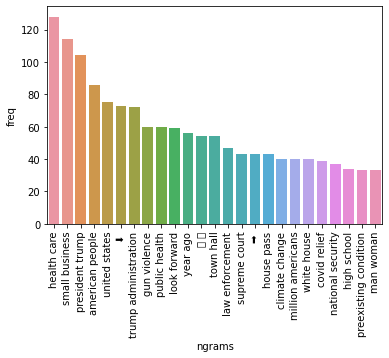

In [17]:
sns.barplot(x="ngrams", y = 'freq', data=df_ngram[0:25])
plt.xticks(rotation=90)
plt.show()

The bigrams seem pretty intelligible indeed. Healthcare was tweeted about the most, with President Trump as a close second. Small business comes in third. It will be interesting to understand the extent to which themes of health versus economy sort themselves along party lines. Likewise, it will be interesting to understand the sentiment of the tweets mentioning Trump, and the extent to which it falls along party lines or legislative chambers. For example, if we hypothesize that the Senate is the "cooling saucer" of Congress, perhaps senators' tweets refrain from critiquing Trump.

### EDA 2: A first pass at LDA

How do these tokens combine to compose topics in the 116th Congressional tweets? Let's use LDA to take an initial look. First, we'll create our tf-idf matrix.

In [18]:
X = congress_tweets['text']
tf = TfidfVectorizer(tokenizer = rem_punc_stop)

tfidf_matrix =  tf.fit_transform(X)
dense_matrix = tfidf_matrix.todense()

We'll fit the LDA model, arbitrarily starting with five topics.

In [19]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=6, max_iter=20, random_state=0)
lda = lda.fit(dense_matrix)

In [20]:
lda.n_components

6

We'll get the top tokens for each of our five topics, and print them along with our feature names.

In [21]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #{}:".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [22]:
tf_feature_names = tf.get_feature_names()
print_top_words(lda, tf_feature_names, 30)


Topic #0:
gopleader great day overturn trump join navy right time president woman abortion catch thank amp vawa stand today read communist outrageous american putin scam deny willing elect saudi texas impeachment

Topic #1:
amp work business president today act census vote small help federal year need qt government time american support trump people congress program day family continue new election covid week bill

Topic #2:
hall town pm facebook live statement telephone question host join read academy tuesday today rsvp student update happy rd email concern award interested listen teletown day participate thank tune attend

Topic #3:
amp today need health help work family people covid community bill qt act care house americans country year trump time pass thank support president life day american fight worker nation

Topic #4:
de la el en ✔ y ️ para que ➡ por los trial 🔥 join discuss las director una protectthedream branch article impeachment participate del great ope bravery endless

The topics don't seem super well-separated or coherent, so we may have to play around with the number of components. For example, 4 out of 5 of the topics contain "covid" or coronavirus. This might not be totally worrisome, except that they don't appear to be very distinct in other respects -- most mention work and voting, as well as Congress and the president. Topic 3 appears the most distinact, perhaps a bit antagonistic to Trump or impeachment-related -- it is the only one that does not mention the president or health, but "impeachment" as well as words like "crisis," "fight," "act," "people," and "protect."

Checking the topic distributions for separation across our categories of interest: party and Congress vs. Senate. 

In [23]:
topic_dist = lda.transform(tfidf_matrix)
topic_dist

array([[0.02707383, 0.02738738, 0.02706907, 0.67061349, 0.02704933,
        0.22080691],
       [0.04083426, 0.04125272, 0.55701756, 0.27945444, 0.04071338,
        0.04072764],
       [0.04140187, 0.04175805, 0.79209057, 0.04209869, 0.04135451,
        0.04129632],
       ...,
       [0.03093417, 0.84457921, 0.03092301, 0.03155555, 0.03107886,
        0.0309292 ],
       [0.0407707 , 0.04083935, 0.04069267, 0.04084771, 0.04066988,
        0.79617969],
       [0.03311002, 0.0332206 , 0.03302633, 0.83457831, 0.03303303,
        0.03303171]])

In [24]:
topic_dist_df = pd.DataFrame(topic_dist, columns = ["Topic " + str(x) for x in range(0, lda.n_components)])
df_w_topics = topic_dist_df.join(congress_tweets.reset_index())
df_w_topics.head()

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,index,tweet_id,screen_name,datetime,...,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
0,0.027074,0.027387,0.027069,0.670613,0.027049,0.220807,36257,1.276160e+18,RepDavid,2020-06-25T10:22:13-04:00,...,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[adopt, olivia, spend, great, time, learn, ari..."
1,0.040834,0.041253,0.557018,0.279454,0.040713,0.040728,548996,1.082280e+18,RepSeanMaloney,2019-01-07T09:33:39-05:00,...,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[suppose, trump, seriously, literally, steel, ..."
2,0.041402,0.041758,0.792091,0.042099,0.041355,0.041296,652347,1.322270e+18,RepSteveChabot,2020-10-30T16:24:14-04:00,...,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[thank, lieutenant, mike, tarr, fire, chief, o..."
3,0.029246,0.029720,0.495703,0.386749,0.029187,0.029394,267614,1.103730e+18,SenatorRisch,2019-03-07T13:33:23-05:00,...,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[remark, amfreesyria, share, concern, devastat..."
4,0.046964,0.048195,0.047017,0.048481,0.762032,0.047310,344386,1.097350e+18,RepThomasMassie,2019-02-17T23:35:06-05:00,...,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, montcolp, lelandshow, realdon..."


In [25]:
grouped = df_w_topics.groupby('party')
for i in df_w_topics.columns[0:lda.n_components]:
    print(grouped[i].mean().sort_values(ascending=False))

party
Republican     0.086381
Democrat       0.068688
Independent    0.060506
Name: Topic 0, dtype: float64
party
Democrat       0.225669
Republican     0.211549
Independent    0.186726
Name: Topic 1, dtype: float64
party
Independent    0.083298
Republican     0.081000
Democrat       0.075538
Name: Topic 2, dtype: float64
party
Independent    0.501111
Democrat       0.467443
Republican     0.445942
Name: Topic 3, dtype: float64
party
Democrat       0.076882
Republican     0.072967
Independent    0.059347
Name: Topic 4, dtype: float64
party
Independent    0.109013
Republican     0.102162
Democrat       0.085779
Name: Topic 5, dtype: float64


In [26]:
grouped = df_w_topics.groupby('position')
for i in df_w_topics.columns[0:lda.n_components]:
    print(grouped[i].mean().sort_values(ascending=False))
    

position
Rep    0.075290
Sen    0.073718
Name: Topic 0, dtype: float64
position
Sen    0.223226
Rep    0.219712
Name: Topic 1, dtype: float64
position
Rep    0.077585
Sen    0.077190
Name: Topic 2, dtype: float64
position
Sen    0.469764
Rep    0.456787
Name: Topic 3, dtype: float64
position
Rep    0.078425
Sen    0.066244
Name: Topic 4, dtype: float64
position
Rep    0.092201
Sen    0.089859
Name: Topic 5, dtype: float64


## Sentiment Analysis

Next, let's analyze the sentiments contained within the tweets. You may use TextBlob or another library for these tasks. Do the following:

* Choose two legislators, one who you think will be more liberal and one who you think will be more conservative, and analyze their sentiment and/or subjectivity scores per tweet. For instance, you might do two scatterplots that plot each legislator's sentiment against their subjectivity, or two density plots for their sentiments. Do the scores match what you thought?
* Plot two more visualizations like the ones you chose in the first part, but do them to compare (1) Democrats v. Republicans and (2) Senators v. Representatives 

`TextBlob` has already been imported in the top cell.

In [29]:
#Convert name_wikipedia column to string 
congress_tweets['name_wikipedia'] = congress_tweets.name_wikipedia.apply(str)
congress_tweets

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens
36257,1.276160e+18,RepDavid,2020-06-25T10:22:13-04:00,"Before adopting Olivia, we spent a great amoun...",David Schweikert,Rep,3-Jan-13,3/3/1962,M,AZ,6,Republican,"1,252,401","1,161,167","1,025,232","1,233,654","[adopt, olivia, spend, great, time, learn, ari..."
548996,1.082280e+18,RepSeanMaloney,2019-01-07T09:33:39-05:00,Are we supposed to take Trump seriously or lit...,Sean Patrick Maloney,Rep,3-Jan-13,7/30/1966,M,NY,18,Democrat,"2,819,533","4,556,118","4,485,741","2,490,431","[suppose, trump, seriously, literally, steel, ..."
652347,1.322270e+18,RepSteveChabot,2020-10-30T16:24:14-04:00,Thank you to Lieutenant Mike Tarr and Fire Chi...,Steve Chabot,Rep,3-Jan-11,1/22/1953,M,OH,1,Republican,"2,841,005","2,394,164","2,827,709","2,661,437","[thank, lieutenant, mike, tarr, fire, chief, o..."
267614,1.103730e+18,SenatorRisch,2019-03-07T13:33:23-05:00,Made remarks to @AmFreeSyria sharing my concer...,Jim Risch,Sen,3-Jan-09,5/3/1943,M,ID,Senate,Republican,"409,055","189,765","212,787","420,911","[remark, amfreesyria, share, concern, devastat..."
344386,1.097350e+18,RepThomasMassie,2019-02-17T23:35:06-05:00,@jeroneanderson @MontcoLP @LelandShow @realDon...,Thomas Massie,Rep,13-Nov-12,1/13/1971,M,KY,4,Republican,"1,202,971","628,854","679,370","1,087,190","[jeroneanderson, montcolp, lelandshow, realdon..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
808467,1.247970e+18,RepBrianBabin,2020-04-08T15:32:28-04:00,RT @Jim_Jordan House Democrats are already dem...,Brian Babin,Rep,3-Jan-15,3/23/1948,M,TX,36,Republican,"4,685,047","3,877,868","3,308,124","4,569,843","[jimjordan, house, democrats, demand, illegal,..."
708752,1.313910e+18,RepDwightEvans,2020-10-07T14:27:37-04:00,RT @SigneWilk Our super spreader president mot...,Dwight Evans,Rep,14-Nov-16,5/16/1954,M,PA,3,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434","[signewilk, super, spreader, president, motor]"
7587,1.252290e+18,RepMarthaRoby,2020-04-20T13:41:44-04:00,I'm confident Congress will act this week to r...,Martha Roby,Rep,3-Jan-11,7/27/1976,F,AL,2,Republican,"1,318,255","729,547","795,696","1,255,925","[confident, congress, act, week, replenish, re..."
930878,1.088620e+18,RepSeanDuffy,2019-01-24T21:13:15-05:00,RT @LaurenBlanch12 Studied extra this week for...,Sean Duffy,Rep,3-Jan-11,10/3/1971,M,WI,7,Republican,"1,405,284","1,382,536","1,620,985","1,407,966","[laurenblanch, study, extra, week, finalexam, ..."


In [30]:
#Conservative rep - Chip Roy
#congress_tweets.loc[congress_tweets['name_wikipedia'] == 'Chip Roy'] -- ok so this doesn't matter I get the same number of tweets (19) with .loc as I do with the code below
congress_tweets['tokens'] = congress_tweets['tokens'].map(lambda text: ' '.join(text))
roy_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Chip Roy']
roy_tweets['polarity'] = roy_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
roy_tweets['subjectivity'] = roy_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
roy_tweets

<ipython-input-30-55856ea96c85>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roy_tweets['polarity'] = roy_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-30-55856ea96c85>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  roy_tweets['subjectivity'] = roy_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity,subjectivity
774657,1.138850e+18,RepChipRoy,2019-06-12T12:40:04-04:00,"RT @ESCochrane Chip Roy, the first to block th...",Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",escochrane chip roy block disaster relief bill...,0.000000,0.000000
781867,1.169610e+18,RepChipRoy,2019-09-05T10:01:22-04:00,"2,347 ounces of heroin was seized on the south...",Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",ounce heroin seize southw border july stateofo...,0.000000,0.000000
802508,1.234970e+18,RepChipRoy,2020-03-03T17:49:58-05:00,I had the privilege of meeting with @ICEgov to...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",privilege meeting icegov today tell lack resou...,0.154167,0.670833
792018,1.201550e+18,RepChipRoy,2019-12-02T12:28:47-05:00,Annual employer-sponsored family insurance top...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",annual employersponsored family insurance new ...,0.174091,0.498636
766784,1.110620e+18,RepChipRoy,2019-03-26T15:24:49-04:00,RT @RepRonWright Read this! Having just return...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",repronwright read return border strongly concu...,-0.022222,0.444444
803413,1.237850e+18,RepChipRoy,2020-03-11T17:36:31-04:00,The bill continues to allow the warrantless su...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",bill continue allow warrantless surveillance a...,0.104167,0.500000
781724,1.168990e+18,RepChipRoy,2019-09-03T16:38:55-04:00,Hey #TX21! \n\nSouth Texas Veterans Health Car...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",hey tx south texas veterans health care system...,0.116667,0.400000
793164,1.204510e+18,RepChipRoy,2019-12-10T16:23:27-05:00,"In November, small business optimism posted th...",Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",november small business optimism post large mo...,-0.017857,0.414286
775196,1.140620e+18,RepChipRoy,2019-06-17T10:11:57-04:00,@JoshuaRush @HouseGOP @SpeakerPelosi @realDona...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",joshuarush housegop speakerpelosi realdonaldtr...,0.000000,0.000000
771960,1.128340e+18,RepChipRoy,2019-05-14T12:42:02-04:00,Thanks to @JoeTalkShow for having me on yester...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",thank joetalkshow yesterday discuss letter cou...,0.000000,0.000000


In [31]:
#Liberal rep - Ted Lieu
lieu_tweets = congress_tweets[congress_tweets.name_wikipedia == 'Ted Lieu']
lieu_tweets['polarity'] = lieu_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
lieu_tweets['subjectivity'] = lieu_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
lieu_tweets

<ipython-input-31-5153264227f1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lieu_tweets['polarity'] = lieu_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-31-5153264227f1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lieu_tweets['subjectivity'] = lieu_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)


,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity,subjectivity
73844,1.131250e+18,RepTedLieu,2019-05-22T13:36:56-04:00,Pleasure to meet with @ASCAP CEO @IMPaulWillia...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",pleasure meet ascap ceo impaulwilliams – legen...,0.492857,0.717857
59223,1.092090e+18,RepTedLieu,2019-02-03T11:07:55-05:00,RT @amjoyshow .@RepTedLieu: Nancy Pelosi is a ...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",amjoyshow reptedlieu nancy pelosi badass real ...,-0.300000,0.650000
76272,1.138460e+18,RepTedLieu,2019-06-11T10:50:34-04:00,RT @HouseJudiciary HAPPENING TODAY: @HouseJudi...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",housejudiciary happen today housejudiciary cha...,-0.075000,0.050000
102221,1.207000e+18,RepTedLieu,2019-12-17T13:25:25-05:00,@senatemajldr More than 275 Bipartisan bills #...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",senatemajldr bipartisan bill forthepeople pass...,0.000000,0.000000
98772,1.197310e+18,RepTedLieu,2019-11-20T19:05:36-05:00,RT @HouseDemocrats The Fourth Day of the Publi...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",housedemocrat fourth day public hearing presid...,0.000000,0.033333
96708,1.192450e+18,RepTedLieu,2019-11-07T09:38:41-05:00,"NEW: Greatly needing U.S. support, Ukraine's g...",Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",new greatly need support ukraines government n...,0.178788,0.359848
104916,1.217090e+18,RepTedLieu,2020-01-14T09:30:35-05:00,Now accepting submissions for our Spring 2020 ...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",accept submission spring congressional art com...,0.205000,0.520000
142685,1.301190e+18,RepTedLieu,2020-09-02T12:00:02-04:00,This is outrageous. Teachers are being forced ...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",outrageous teacher force use saving buy person...,-0.166667,0.600000
120212,1.250890e+18,RepTedLieu,2020-04-16T17:10:39-04:00,RT @AsmMuratsuchi During this unprecedented ti...,Ted Lieu,Rep,3-Jan-15,3/29/1969,M,CA,33,Democrat,"4,483,814","8,753,792","7,854,285","4,839,958",asmmuratsuchi unprecedented time south bay lea...,0.500000,0.950000


In [32]:
#Combine data frames
tweets_combined = [roy_tweets, lieu_tweets]
sentiment_1 = pd.concat(tweets_combined)

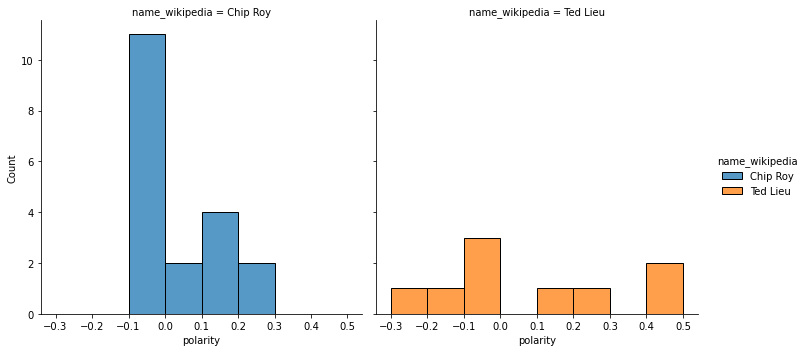

In [34]:
#Plot sentiment polarity for conservative & liberal legislators
sns.displot(sentiment_1, x="polarity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

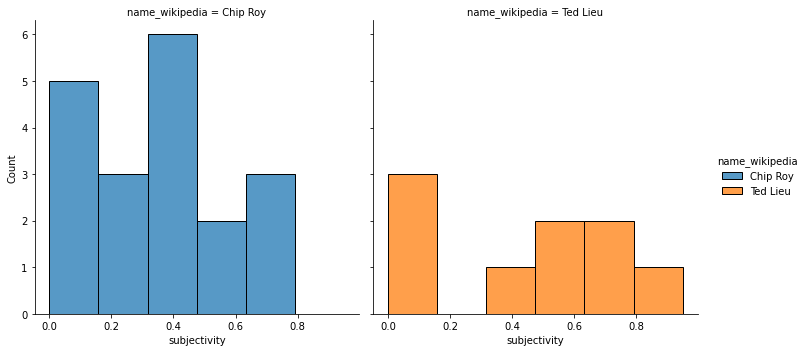

In [35]:
#Plot sentiment subjectivity for conservative & liberal legislators
sns.displot(sentiment_1, x="subjectivity", hue = "name_wikipedia", col = "name_wikipedia")
plt.show()

In [36]:
#Polarity & subjectivity for Dem tweets 
dem_tweets = congress_tweets[congress_tweets.party == 'Democrat']
dem_tweets['polarity'] = dem_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
dem_tweets['subjectivity'] = dem_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#Polarity & subjectivity for Republican tweets 
repub_tweets = congress_tweets[congress_tweets.party == 'Republican']
repub_tweets['polarity'] = repub_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
repub_tweets['subjectivity'] = repub_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#Combine data frames
party_combined = [dem_tweets, repub_tweets]
sentiment_2 = pd.concat(party_combined)

<ipython-input-36-c0ab152cc0ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dem_tweets['polarity'] = dem_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-36-c0ab152cc0ef>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dem_tweets['subjectivity'] = dem_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
<ipython-input-36-c0ab152cc0ef>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

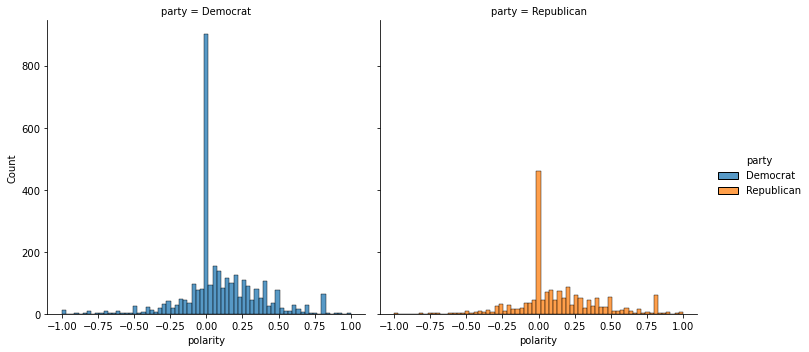

In [37]:
#Plot sentiment polarity for Dems vs. Republicans
sns.displot(sentiment_2, x="polarity", hue = "party", col = "party")
plt.show()

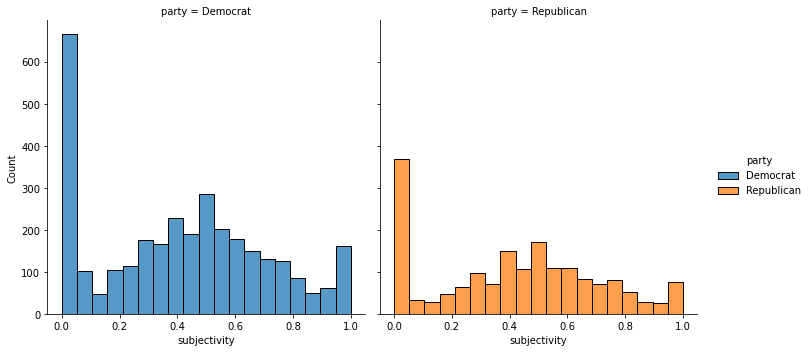

In [38]:
#Plot sentiment subjectivity for Dems vs. Republicans
sns.displot(sentiment_2, x="subjectivity", hue = "party", col = "party")
plt.show()

In [39]:
#Polarity & subjectivity for Senate tweets
sen_tweets = congress_tweets[congress_tweets.position == 'Sen']
sen_tweets['polarity'] = sen_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
sen_tweets['subjectivity'] = sen_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#Polarity & subjectivity for House tweets
rep_tweets = congress_tweets[congress_tweets.position == 'Rep']
rep_tweets['polarity'] = rep_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
rep_tweets['subjectivity'] = rep_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)

#Combine data frames
congress_combined = [sen_tweets, rep_tweets]
sentiment_3 = pd.concat(congress_combined)

<ipython-input-39-77e8c3ee7ac5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sen_tweets['polarity'] = sen_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.polarity)
<ipython-input-39-77e8c3ee7ac5>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sen_tweets['subjectivity'] = sen_tweets['tokens'].map(lambda text: TextBlob(text).sentiment.subjectivity)
<ipython-input-39-77e8c3ee7ac5>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

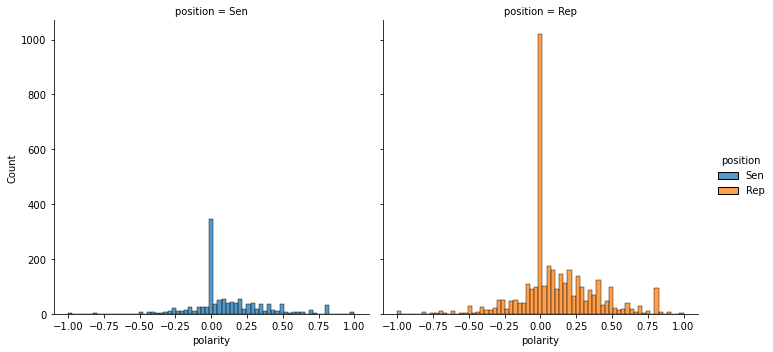

In [40]:
#Plot sentiment polarity for Senate vs. House
sns.displot(sentiment_3, x="polarity", hue = "position", col = "position")
plt.show()

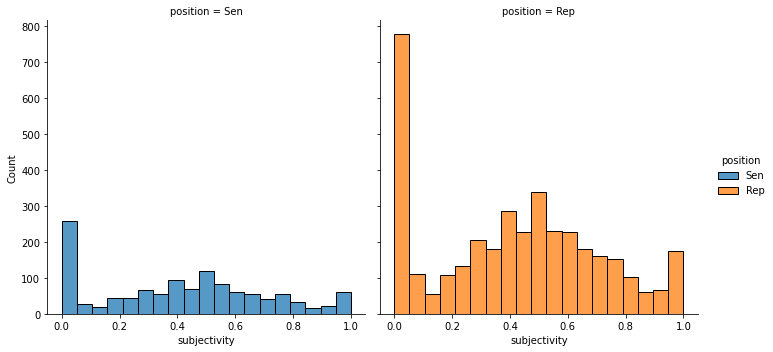

In [41]:
#Plot sentiment subjectivity for Senate vs. House
sns.displot(sentiment_3, x="subjectivity", hue = "position", col = "position")
plt.show()

## Featurization

Before going to classification, explore different featurization techniques. Create three dataframes or arrays to represent your text features, specifically:

* Features engineered from your previous analysis. For example, word counts, sentiment scores, topic model etc.
* A term frequency-inverse document frequency matrix. 
* An embedding-based featurization (like a document averaged word2vec)

In the next section, you will experiment with each of these featurization techniques to see which one produces the best classifications.

### Engineered Text Features

In [42]:
# Engineered Features
word_count = pd.DataFrame([len(str(x).split()) for x in congress_tweets['tokens']], columns = ['word_count'])
word_count

,word_count
0,42
1,10
2,10
3,24
4,7
...,...
4995,16
4996,5
4997,23
4998,10


In [43]:
character_count = pd.DataFrame([len(x) for x in congress_tweets['text']], columns = ['character_count'])
character_count

,character_count
0,755
1,110
2,156
3,325
4,102
...,...
4995,211
4996,162
4997,279
4998,157


In [ ]:
#already generated from EDA

topic_dist_df

In [46]:
# review from sentiment analysis goes here
sentiment_combined = [sentiment_1, sentiment_2, sentiment_3]
sentiment_score = pd.concat(sentiment_combined).reset_index(drop=True)
sentiment_score

,tweet_id,screen_name,datetime,text,name_wikipedia,position,joined_congress_date,birthday,gender,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity,subjectivity
0,1.138850e+18,RepChipRoy,2019-06-12T12:40:04-04:00,"RT @ESCochrane Chip Roy, the first to block th...",Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",escochrane chip roy block disaster relief bill...,0.000000,0.000000
1,1.169610e+18,RepChipRoy,2019-09-05T10:01:22-04:00,"2,347 ounces of heroin was seized on the south...",Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",ounce heroin seize southw border july stateofo...,0.000000,0.000000
2,1.234970e+18,RepChipRoy,2020-03-03T17:49:58-05:00,I had the privilege of meeting with @ICEgov to...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",privilege meeting icegov today tell lack resou...,0.154167,0.670833
3,1.201550e+18,RepChipRoy,2019-12-02T12:28:47-05:00,Annual employer-sponsored family insurance top...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",annual employersponsored family insurance new ...,0.174091,0.498636
4,1.110620e+18,RepChipRoy,2019-03-26T15:24:49-04:00,RT @RepRonWright Read this! Having just return...,Chip Roy,Rep,3-Jan-19,8/7/1972,M,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",repronwright read return border strongly concu...,-0.022222,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10008,1.247970e+18,RepBrianBabin,2020-04-08T15:32:28-04:00,RT @Jim_Jordan House Democrats are already dem...,Brian Babin,Rep,3-Jan-15,3/23/1948,M,TX,36,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",jimjordan house democrats demand illegal immig...,-0.277778,0.388889
10009,1.313910e+18,RepDwightEvans,2020-10-07T14:27:37-04:00,RT @SigneWilk Our super spreader president mot...,Dwight Evans,Rep,14-Nov-16,5/16/1954,M,PA,3,Democrat,"2,970,733","2,926,441","2,990,274","2,680,434",signewilk super spreader president motor,0.333333,0.666667
10010,1.252290e+18,RepMarthaRoby,2020-04-20T13:41:44-04:00,I'm confident Congress will act this week to r...,Martha Roby,Rep,3-Jan-11,7/27/1976,F,AL,2,Republican,"1,318,255","729,547","795,696","1,255,925",confident congress act week replenish resource...,0.083333,0.411111
10011,1.088620e+18,RepSeanDuffy,2019-01-24T21:13:15-05:00,RT @LaurenBlanch12 Studied extra this week for...,Sean Duffy,Rep,3-Jan-11,10/3/1971,M,WI,7,Republican,"1,405,284","1,382,536","1,620,985","1,407,966",laurenblanch study extra week finalexam repsea...,0.000000,0.100000


In [47]:
# combine into dataframe
engineered_features = topic_dist_df.join(character_count).join(word_count).join(sentiment_score)
engineered_features

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,character_count,word_count,tweet_id,screen_name,...,state,district_number,party,trump_2016_state_share,clinton_2016_state_share,obama_2012_state_share,romney_2012_state_share,tokens,polarity,subjectivity
0,0.027074,0.027387,0.027069,0.670613,0.027049,0.220807,755,42,1.138850e+18,RepChipRoy,...,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",escochrane chip roy block disaster relief bill...,0.000000,0.000000
1,0.040834,0.041253,0.557018,0.279454,0.040713,0.040728,110,10,1.169610e+18,RepChipRoy,...,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",ounce heroin seize southw border july stateofo...,0.000000,0.000000
2,0.041402,0.041758,0.792091,0.042099,0.041355,0.041296,156,10,1.234970e+18,RepChipRoy,...,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",privilege meeting icegov today tell lack resou...,0.154167,0.670833
3,0.029246,0.029720,0.495703,0.386749,0.029187,0.029394,325,24,1.201550e+18,RepChipRoy,...,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",annual employersponsored family insurance new ...,0.174091,0.498636
4,0.046964,0.048195,0.047017,0.048481,0.762032,0.047310,102,7,1.110620e+18,RepChipRoy,...,TX,21,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",repronwright read return border strongly concu...,-0.022222,0.444444
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,0.033881,0.034112,0.033876,0.830301,0.033892,0.033938,211,16,1.285340e+18,SenJohnHoeven,...,ND,Senate,Republican,"216,794","93,758","124,827","188,163",senate vote confirm russvought director omb to...,0.000000,0.000000
4996,0.052753,0.052968,0.052731,0.052858,0.052734,0.735956,162,5,1.231930e+18,RepPeteOlson,...,TX,22,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",year ago believe miracle yes miracleonice ⁦usa...,0.000000,0.000000
4997,0.030934,0.844579,0.030923,0.031556,0.031079,0.030929,279,23,1.307820e+18,SenTedCruz,...,TX,Senate,Republican,"4,685,047","3,877,868","3,308,124","4,569,843",davidlippman sentedcruz write ope fox news exp...,0.000000,0.000000
4998,0.040771,0.040839,0.040693,0.040848,0.040670,0.796180,157,10,1.120430e+18,SenatorBraun,...,IN,Senate,Republican,"1,557,286","1,033,126","1,152,887","1,420,543",nra speaker lineup nraila leadership forum lin...,0.000000,0.000000


### Bag-of-words or Tf-idf

In [ ]:
# Frequency Based featurization
tfidf_matrix

## Word Embeddings

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

Using our tokenized corpus to update the Google News embeddings. 

In [ ]:
# retrain cfpb['tokens'] model so it has the same dimensions as the google vector

import multiprocessing

word2vec_model = gensim.models.Word2Vec(size = 300, window=5, min_count = 1,
                                        workers = (multiprocessing.cpu_count()))
word2vec_model.build_vocab(congress_tweets['tokens'])

In [ ]:
# the intersect code that loads the Google News embeddings

# set lockf = 1 to allow updating

word2vec_model.intersect_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', lockf=1.0, binary=True)

# Finish training model
word2vec_model.train(congress_tweets['tokens'], total_examples=3, epochs = 5)

Exploring word embeddings (with Google News loaded) using t-SNE visualization. 

In [ ]:
# Filter the list of vectors to include only those that Word2Vec has a vector for
#words = list(model.wv.vocab)
vector_list = [word2vec_model.wv.__getitem__(word) for word in word2vec_model.wv.vocab]

# Create a list of the words corresponding to these vectors
words_filtered = [word for word in word2vec_model.wv.vocab]

# Zip the words together with their vector representations
word_vec_zip = zip(words_filtered, vector_list)

# Cast to a dict so we can turn it into a dataframe
word_vec_dict = dict(word_vec_zip)
word_vec_df = pd.DataFrame.from_dict(word_vec_dict, orient='index')
word_vec_df.shape

Looks lke our word embeddings pulled out 4,079 unique tokens that matched the criteria for Word2Vec (do we know what these criteria are??) 

In [ ]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'pca', perplexity = 30)

# Use 400 rows to speed up training time
tsne_df = tsne.fit_transform(word_vec_df[:400])

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)

# Use adjustText to jitter the labels
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], word_vec_df.index[word], fontsize = 10))
    
adjust_text(texts, force_points = 0.4, force_text = 0.2, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

I don't see so much separation, but can see some potentially meaningful proximities? 

Towards the upper right: bank, credit, firm, investment, trade, product 

Also in the vicinity: children, wife 

And then leftish: comment, story, tell 

Going to try PCA on the vectors... 

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = word2vec_model.wv.__getitem__(word2vec_model.wv.vocab)
# scale the data
X_std = StandardScaler().fit_transform(X)

# make a PCA
w2v_pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

# fit the standardized data
Y_pca = w2v_pca.fit_transform(X_std)

sns.scatterplot(x = Y_pca[:, 0], y = Y_pca[:, 1])

In [ ]:
import random
random.seed(10)
rando = random.sample(list(word2vec_model.wv.vocab), 30)

X1 = word2vec_model.wv.__getitem__(rando)
pca1 = PCA(n_components=2)
result = w2v_pca.fit_transform(X1)
result_df = pd.DataFrame(result, columns = ['PC1', 'PC2'], index = rando)
sns.scatterplot(x = 'PC1', y = 'PC2', data = result_df)

from adjustText import adjust_text
texts = []

# Append words to list
for word in result_df.index:
    texts.append(plt.text(result_df.loc[word, 'PC1'], result_df.loc[word, 'PC2'], word, fontsize = 8))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

Lol well... Interesting that both "protect" and "govt" are quite far from the mass of the (randomly sampled) vocabulary, and also somewhat far from each other. Also "october" and "twitter" being close together...? Something about the leadup to the November election? Sorry this is not a particularly well thought out interpretation LOL

Creating the averaged embeddings for each document. 

In [ ]:
import numpy as np

# Function to average word embeddings for a document; 
#use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.

#added the else clause in the return statement for any docs that have no words in the model vocab

def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in word2vec_model.wv.vocab]
    return np.mean(word2vec_model.wv.__getitem__(doc), axis=0) if len(doc) > 0 else np.empty(word2vec_model.vector_size)

In [ ]:
#np.vstack takes the list from the list comprehension code
# and "stacks" vertically to form a single array 
docavgs = np.vstack([document_vector(word2vec_model, x) for x in congress_tweets['tokens']])

In [ ]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'pca', perplexity = 30)

# Use 400 rows to speed up training time
tsne_df = tsne.fit_transform(docavgs)

fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(x = tsne_df[:, 0], y = tsne_df[:, 1], alpha = 0.5)


Lol just one big blob :( 

Just curious... going to PCA the word averaged document embeddings. 

In [ ]:
X = docavgs
# scale the data
X_std = StandardScaler().fit_transform(X)

# make a PCA
w2v_pca = PCA(n_components=2) #set n_components to 2 to graph in 2-D

# fit the standardized data
Y_pca = w2v_pca.fit_transform(X_std)

sns.scatterplot(x = Y_pca[:, 0], y = Y_pca[:, 1])

Okay two clusters !! 

In [ ]:
pca_df

In [ ]:
pca_df = pd.DataFrame(data = Y_pca
             , columns = ['principal component 1', 'principal component 2'])

plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Document Averages",fontsize=20)
targets = set(congress_tweets['party'])
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = congress_tweets.reset_index()['party'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(['Republican', 'Democrat'],prop={'size': 15})

from adjustText import adjust_text
texts = []

# Append name_wikipedia to list
# this looks very bad lol, too many names
'''for word in pca_df.index:
    texts.append(plt.text(pca_df.loc[word, 'principal component 1'],
                          pca_df.loc[word, 'principal component 1'], 
                          congress_tweets.reset_index().loc[word, 'name_wikipedia'], fontsize = 8))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))'''

plt.show()

In [ ]:
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of Document Averages",fontsize=20)
targets = set(congress_tweets['position'])
colors = ['m', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = congress_tweets.reset_index()['position'] == target
    plt.scatter(pca_df.loc[indicesToKeep, 'principal component 1']
               , pca_df.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

plt.legend(targets,prop={'size': 15})
plt.show()

Um... If there is a separation, doesn't look like it's super meaningful to our questions lol. 

### Doc2Vec

In [ ]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# binarize label
lb_style = LabelBinarizer()
y = congress_tweets['party'] = lb_style.fit_transform(congress_tweets['party'])

# train/test split
train, test = train_test_split(congress_tweets, test_size=0.2, random_state=42)

In [ ]:
ct_train_tagged = train.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.party]), axis=1)
ct_test_tagged = test.apply(lambda r: TaggedDocument(words=r['tokens'], tags=[r.party]), axis=1)

ct_train_tagged

In [ ]:
from multiprocessing import cpu_count
from tqdm import tqdm

model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cpu_count())
model_dbow.build_vocab([x for x in tqdm(ct_train_tagged.values)])

In [ ]:
from sklearn import utils

for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(ct_train_tagged.values)]), 
                     total_examples=len(ct_train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

In [ ]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
y_train, X_train = vec_for_learning(model_dbow, ct_train_tagged)
y_test, X_test = vec_for_learning(model_dbow, ct_test_tagged)

In [ ]:
from sklearn.preprocessing import StandardScaler

X_std = StandardScaler().fit_transform(X_train)

In [ ]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 

imba_pipeline = make_pipeline(SMOTE(random_state=10), 
                             LogisticRegression())

param_grid = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
              'logisticregression__solver' : ['newton-cg', 'lbfgs', 'saga'],
             "logisticregression__max_iter": [1000], 
             'logisticregression__l1_ratio': np.arange(0, 1, 0.2)}

log_grid_reg3 = GridSearchCV(imba_pipeline, param_grid, cv=3, iid=False, 
                            scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs = -1,  
                           refit = 'accuracy') 
log_grid_reg3.fit(X_train, y_train)



In [ ]:
metrics = ["params", "mean_test_accuracy", "mean_test_precision", 
           "mean_test_recall", "mean_test_f1", "mean_fit_time"]

for i in metrics:
    print(i, ":", log_grid_reg3.cv_results_[i][log_grid_reg3.best_index_])

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = log_grid_reg3.best_estimator_[1].predict(StandardScaler().fit_transform(X_test))

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
df_cm.index = ["Republican", "Democrat"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Confusion Matrix')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Word Embedding

In [ ]:
# Load Word2Vec model from Google; OPTIONAL depending on your computational resources (the file is ~1 GB)
# Also note that this file path assumes that the word vectors are underneath 'data'; you may wish to point to the CSS course repo and change the path
# or move the vector file to the project repo 

model = gensim.models.KeyedVectors.load_word2vec_format('data/GoogleNews-vectors-negative300.bin.gz', binary = True) 

In [ ]:
import numpy as np
# Function to average word embeddings for a document; use examples from lab to apply this function. You can use also other techniques such as PCA and doc2vec instead.
def document_vector(word2vec_model, doc):
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model.wv.__getitem__(doc), axis=0)

In [ ]:
# embedding based featurization
model = gensim.models.Word2Vec(congress_tweets['tokens'], size=100, window=5, \
                               min_count=5, sg=0, alpha=0.025, iter=5, batch_words=10000)

In [ ]:
model.wv.vocab

In [ ]:
doc = [word for word in congress_tweets.reset_index()['tokens'][0] if word in model.wv.vocab]

In [ ]:
document_vector(model, congress_tweets.reset_index()['tokens'][0])

In [ ]:
test = [document_vector(model, x) for x in congress_tweets.reset_index()['tokens']]

## Classification

Either use cross-validation or partition your data with training/validation/test sets for this section. Do the following:

* Choose a supervised learning algorithm such as logistic regression, random forest etc. 
* Train six models. For each of the three dataframes you created in the featurization part, train one model to predict whether the author of the tweet is a Democrat or Republican, and a second model to predict whether the author is a Senator or Representative.
* Report the accuracy and other relevant metrics for each of these six models.
* Choose the featurization technique associated with your best model. Combine those text features with non-text features. Train two more models: (1) A supervised learning algorithm that uses just the non-text features and (2) a supervised learning algorithm that combines text and non-text features. Report accuracy and other relevant metrics. 

If time permits, you are encouraged to use hyperparameter tuning or AutoML techniques like TPOT, but are not explicitly required to do so.

### Train Six Models with Just Text

### Jasmine

In [52]:
# six models ([engineered features, frequency-based, embedding] * [democrat/republican, senator/representative])

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Engineered Features (trying this without to resolve error below)
#dataframes = [engineered_features]

#featurization_technique = ['Engineered Text Features']

In [79]:
engineered_features_df = pd.DataFrame(engineered_features)

In [80]:
engineered_features_df = engineered_features_df.drop(['tokens', 'tweet_id','screen_name',
                                                      'datetime', 'text', 'joined_congress_date',
                                                      'birthday', 'position', 'party', 'district_number',
                                                     'name_wikipedia'], axis = 1)

In [85]:
list(engineered_features_df.columns)

['Topic 0',
 'Topic 1',
 'Topic 2',
 'Topic 3',
 'Topic 4',
 'Topic 5',
 'character_count',
 'word_count',
 'polarity',
 'subjectivity',
 'gender_F',
 'gender_M',
 'state_AK',
 'state_AL',
 'state_AR',
 'state_AZ',
 'state_CA',
 'state_CO',
 'state_CT',
 'state_DC',
 'state_DE',
 'state_FL',
 'state_GA',
 'state_HI',
 'state_IA',
 'state_ID',
 'state_IL',
 'state_IN',
 'state_KS',
 'state_KY',
 'state_LA',
 'state_MA',
 'state_MD',
 'state_ME',
 'state_MI',
 'state_MN',
 'state_MO',
 'state_MS',
 'state_MT',
 'state_NC',
 'state_ND',
 'state_NE',
 'state_NH',
 'state_NJ',
 'state_NM',
 'state_NV',
 'state_NY',
 'state_OH',
 'state_OK',
 'state_OR',
 'state_PA',
 'state_RI',
 'state_SC',
 'state_SD',
 'state_TN',
 'state_TX',
 'state_UT',
 'state_VA',
 'state_VT',
 'state_WA',
 'state_WI',
 'state_WV',
 'state_WY',
 'trump_2016_state_share_1,090,893',
 'trump_2016_state_share_1,155,389',
 'trump_2016_state_share_1,178,638',
 'trump_2016_state_share_1,202,484',
 'trump_2016_state_share_1

In [83]:
from sklearn.preprocessing import StandardScaler

engineered_features_df = pd.get_dummies(engineered_features_df)
X = StandardScaler().fit_transform(engineered_features_df)

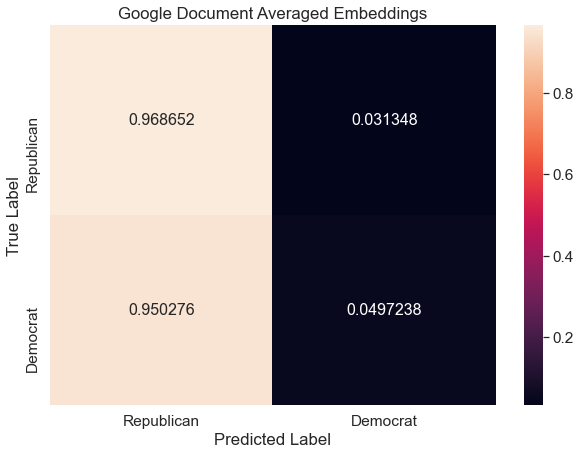

In [86]:
#for dataframe, featurization in zip(dataframes, featurization_technique): (trying to resolve error)
lb_style = LabelBinarizer()
y = lb_style.fit_transform(congress_tweets['party'].replace('Independent','Democrat'))

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    train_size = .80, 
                                                    test_size=0.20, 
                                                    random_state = 10)
# create a model
logit_reg = LogisticRegression()

# fit the model
logit_model = logit_reg.fit(X_train, y_train.ravel())

y_pred = logit_model.predict(X_test)

cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "Republican", 1: "Democrat"})
df_cm.index = ["Republican", "Democrat"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title('Google Document Averaged Embeddings')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

### Paul

In [ ]:
from sklearn.preprocessing import LabelBinarizer

X_std = StandardScaler().fit_transform(np.concatenate((np.array(engineered_features),docavgs), axis = 1))
#X_std

lb = LabelBinarizer()
#y = lb.fit_transform(congress_tweets['party'].replace('Independent', 'Democrat'))

y = congress_tweets['party']

In [ ]:


from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression 

imba_pipeline = make_pipeline(SMOTE(random_state=10), 
                             LogisticRegression())

param_grid = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
              'logisticregression__solver' : ['newton-cg', 'lbfgs', 'saga'],
             "logisticregression__max_iter": [1000], 
             'logisticregression__l1_ratio': np.arange(0, 1, 0.2)}

log_grid_reg3 = GridSearchCV(imba_pipeline, param_grid, cv=3, iid=False, 
                            scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs = -1,  
                           refit = 'accuracy') 
log_grid_reg3.fit(X_std, y.ravel())


In [ ]:
metrics = ["params", "mean_test_accuracy", "mean_test_precision", 
           "mean_test_recall", "mean_test_f1", "mean_fit_time"]

for i in metrics:
    print(i, ":", log_grid_reg3.cv_results_[i][log_grid_reg3.best_index_])

### Audrey

In [ ]:
# turn tfidf matrix into data frame

tfidf_df = pd.DataFrame(tfidf_matrix.todense(), columns = tf.get_feature_names())
tfidf_df

In [ ]:
# join tfidf df with tweets df to enable dropping independents

tweets_plus_tfidf = congress_tweets.reset_index(drop = True).join(tfidf_df, rsuffix = '_right')
# using the rsuffix argument because some columns that correspond to tokens duplicate non-text feature titles
tweets_plus_tfidf

In [ ]:
# drop independents

tweets_plus_tfidf_no_ind = tweets_plus_tfidf[ tweets_plus_tfidf.party != 'Independent' ]
tweets_plus_tfidf_no_ind.head()

In [ ]:
list(tweets_plus_tfidf_no_ind.columns) # look at the column names -- must delete 0-16 again

We create our features, which consist in tf-idf values for each token in each tweet.

In [ ]:
X = tweets_plus_tfidf_no_ind.drop(['tweet_id',
 'screen_name',
 'datetime',
 'text',
 'name_wikipedia',
 'position',
 'joined_congress_date',
 'birthday',
 'gender',
 'state',
 'district_number',
 'party',
 'trump_2016_state_share',
 'clinton_2016_state_share',
 'obama_2012_state_share',
 'romney_2012_state_share',
 'tokens'], axis=1)

We create our vector of target values, y.

In [ ]:
from sklearn.preprocessing import LabelBinarizer

lb_style = LabelBinarizer()
y_party = lb_style.fit_transform(tweets_plus_tfidf_no_ind['party']) # predict party affiliation
y_position = lb_style.fit_transform(tweets_plus_tfidf_no_ind['position']) # predict position

We create our train and test sets, fit a logit model using the training data, and predict y values for the test set.

In [ ]:
target = [y_party, y_position]

target_title = ['Party', 'Senator or Representative?']

cm_cols = [{0: "Republican", 1: "Democrat"}, {0: "Senator", 1: "Representative"}]

cm_cols_index = [["Republican", "Democrat"], ["Senator", "Representative"]]

In [ ]:
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression

for target_vals in target:
    
    imba_pipeline = make_pipeline(SMOTE(random_state=10),
                             LogisticRegression())
    
    param_grid = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet'],
              'logisticregression__solver' : ['newton-cg', 'lbfgs', 'saga'],
             "logisticregression__max_iter": [1000],
             'logisticregression__l1_ratio': numpy.arange(0, 1, 0.2)}
    
    log_grid_reg3 = GridSearchCV(imba_pipeline, param_grid, cv=3, iid=False,
                            scoring=['accuracy', 'precision', 'recall', 'f1'], n_jobs = -1, 
                           refit = 'accuracy')
    
    log_grid_reg3.fit(X, target_vals.ravel())
    
    metrics = ["params", "mean_test_accuracy", "mean_test_precision",
           "mean_test_recall", "mean_test_f1", "mean_fit_time"]
    
    for i in metrics:
        print(i, ":", log_grid_reg3.cv_results_[i][log_grid_reg3.best_index_])

In [ ]:
# re-run the model with the hyperparameters above
from sklearn.metrics import confusion_matrix


for target_vals, target_name, cmc, cmci in zip(target, target_title, cm_cols, cm_cols_index):
    X_train, X_test, y_train, y_test = train_test_split(X, 
                                                        target_vals, 
                                                        train_size = .80, 
                                                        test_size=0.20, 
                                                        random_state = 10)
    
    
    # insert hyperparameters here
    logit_reg = LogisticRegression(l1_ratio = 0.0,
                              #fit_intercept = True,
                              penalty = 'l2',
                              solver = 'newton-cg')
    
    # fit the model
    logit_model = logit_reg.fit(X_train, y_train.ravel())

    y_pred = logit_model.predict(X_test)
    
    cf_matrix = confusion_matrix(y_test, y_pred, normalize = "true")

    df_cm = pd.DataFrame(cf_matrix, range(2),
                      range(2))

    df_cm = df_cm.rename(index=str, columns=cmc)
    df_cm.index = cmci
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4)#for label size
    sns.heatmap(df_cm, 
               annot=True,
               annot_kws={"size": 16},
               fmt='g')

    plt.title(target_name)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

### Two Combined Models

In [ ]:
# two models ([best text features + non-text features] * [democrat/republican, senator/representative])


## Discussion Questions

1. Why do standard preprocessing techniques need to be further customized to a particular corpus?

**Your Answer Here**

2. Did you find evidence for the idea that Democrats and Republicans have different sentiments in their tweets? What about Senators and Representatives?

**Your Answer Here**

3. Why is validating your exploratory and unsupervised learning approaches with a supervised learning algorithm valuable?

**Your Answer Here**

4. Did text only, non-text only, or text and non-text features together perform the best? What is the intuition behind combining text and non-text features in a supervised learning algorithm?

**Your Answer Here**